<a href="https://colab.research.google.com/github/syahrinalfi/MachineLearningTasks/blob/main/6thWeekTasks/SKLearn/Hierarchical_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Nama : Muhammad Alfi Syahrin
* NIM : 1103213144
* Lecture : 6
* Model : Clustering (Hierarchical)


# **Exploration of the Different Linkage Strategies in a Real Dataset**

Computing embedding
Done.
ward :	0.29s
average :	0.32s
complete :	0.38s
single :	0.14s


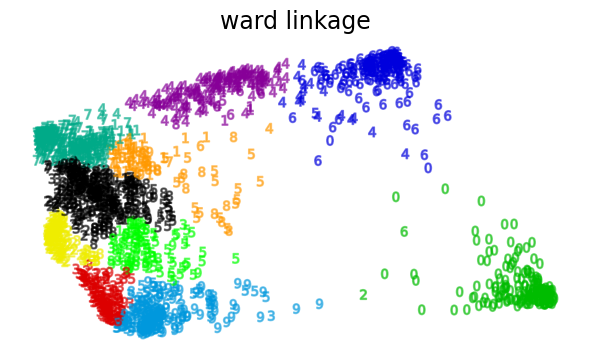

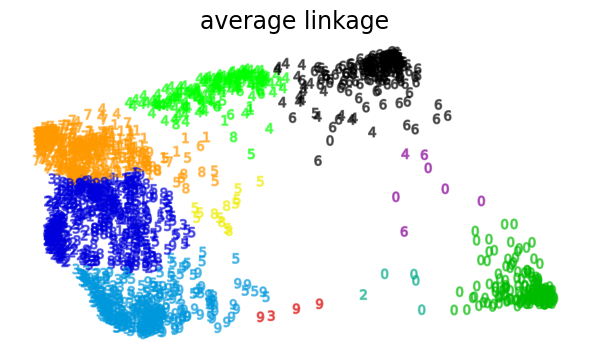

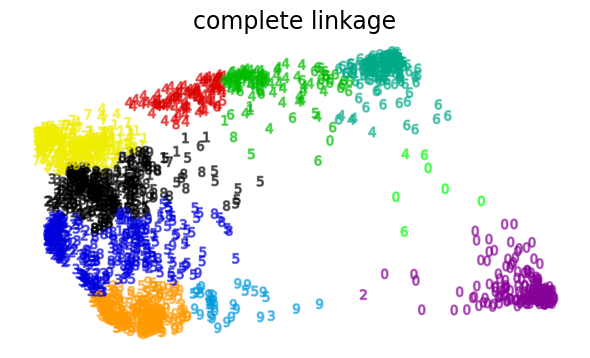

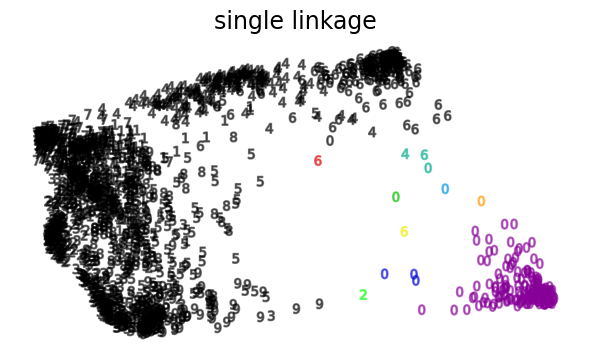

In [ ]:
from time import time

import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets, manifold

digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

np.random.seed(0)


def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for digit in digits.target_names:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

# **Ward Clustering to Split the Image of Coins in Regions**

In [ ]:
from skimage.data import coins

orig_coins = coins()

In [ ]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale

smoothened_coins = gaussian_filter(orig_coins, sigma=2)
rescaled_coins = rescale(
    smoothened_coins,
    0.2,
    mode="reflect",
    anti_aliasing=False,
)

X = np.reshape(rescaled_coins, (-1, 1))

In [ ]:
from sklearn.feature_extraction.image import grid_to_graph

connectivity = grid_to_graph(*rescaled_coins.shape)

In [ ]:
import time as time

from sklearn.cluster import AgglomerativeClustering

print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 27
ward = AgglomerativeClustering(
    n_clusters=n_clusters, linkage="ward", connectivity=connectivity
)
ward.fit(X)
label = np.reshape(ward.labels_, rescaled_coins.shape)
print(f"Elapsed time: {time.time() - st:.3f}s")
print(f"Number of pixels: {label.size}")
print(f"Number of clusters: {np.unique(label).size}")

Compute structured hierarchical clustering...
Elapsed time: 0.653s
Number of pixels: 4697
Number of clusters: 27


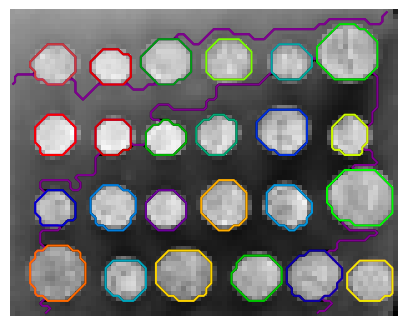

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(rescaled_coins, cmap=plt.cm.gray)
for l in range(n_clusters):
    plt.contour(
        label == l,
        colors=[
            plt.cm.nipy_spectral(l / float(n_clusters)),
        ],
    )
plt.axis("off")
plt.show()

# **Example of Ward algorithm on a Swiss-roll, Comparison of Structured Approaches versus Unstructured Approaches**

In [ ]:
import time as time

import mpl_toolkits.mplot3d
import numpy as np

In [ ]:
from sklearn.datasets import make_swiss_roll

n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise=noise)
X[:, 1] *= 0.5

In [ ]:
from sklearn.cluster import AgglomerativeClustering

print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage="ward").fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print(f"Elapsed time: {elapsed_time:.2f}s")
print(f"Number of points: {label.size}")

Compute unstructured hierarchical clustering...
Elapsed time: 0.21s
Number of points: 1500


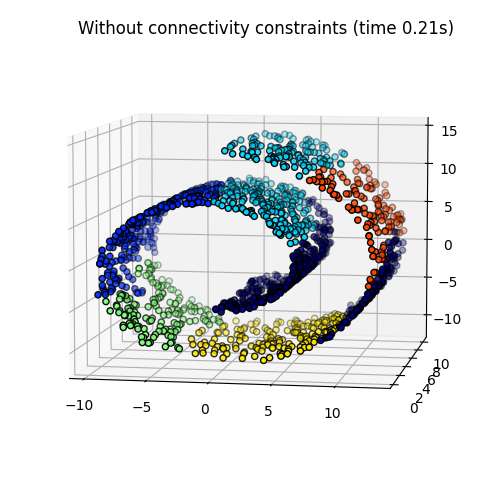

In [ ]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
ax1.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax1.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
_ = fig1.suptitle(f"Without connectivity constraints (time {elapsed_time:.2f}s)")

In [ ]:
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

In [ ]:
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(
    n_clusters=6, connectivity=connectivity, linkage="ward"
).fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print(f"Elapsed time: {elapsed_time:.2f}s")
print(f"Number of points: {label.size}")

Compute structured hierarchical clustering...
Elapsed time: 0.38s
Number of points: 1500


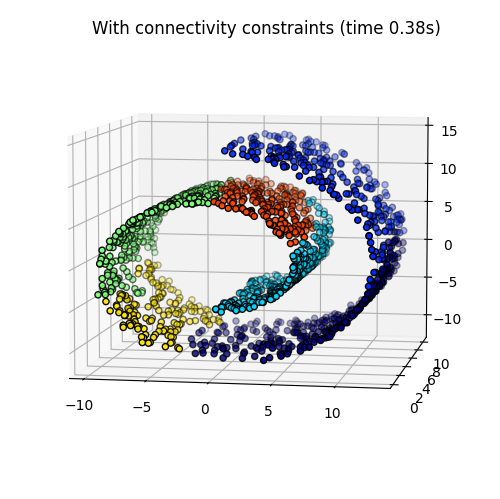

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(121, projection="3d", elev=7, azim=-80)
ax2.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax2.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
fig2.suptitle(f"With connectivity constraints (time {elapsed_time:.2f}s)")

plt.show()

# **Example of Dimensionality Reduction with Feature Agglomeration Based on Ward Hierarchical Clustering**

In [ ]:
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from joblib import Memory
from scipy import linalg, ndimage

from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

In [ ]:
n_samples = 200
size = 40
roi_size = 15
snr = 5.0
np.random.seed(0)

In [ ]:
coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.0
coef[-roi_size:, -roi_size:] = 1.0

X = np.random.randn(n_samples, size**2)
for x in X:
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())

In [ ]:
noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.0)) / linalg.norm(noise, 2)
y += noise_coef * noise

In [ ]:
cv = KFold(2)
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)

In [ ]:
connectivity = grid_to_graph(n_x=size, n_y=size)
ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity, memory=mem)
clf = Pipeline([("ward", ward), ("ridge", ridge)])
clf = GridSearchCV(clf, {"ward__n_clusters": [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X, y)
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.451933, ..., -0.675318],
       ...,
       [ 0.275706, ..., -1.085711]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int64'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[ 0.905206, ...,  0.161245],
       ...,
       [-0.849835, ..., -1.091621]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int64'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.1s, 0.0min
__________________________________________

In [ ]:
f_regression = mem.cache(feature_selection.f_regression)
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([("anova", anova), ("ridge", ridge)])
clf = GridSearchCV(clf, {"anova__percentile": [5, 10, 20]}, cv=cv)
clf.fit(X, y)
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
coef_selection_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[-0.451933, ...,  0.275706],
       ...,
       [-0.675318, ..., -1.085711]]), 
array([ 25.267703, ..., -25.026711]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [ 0.161245, ..., -1.091621]]), 
array([ -27.447268, ..., -112.638768]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [-0.67

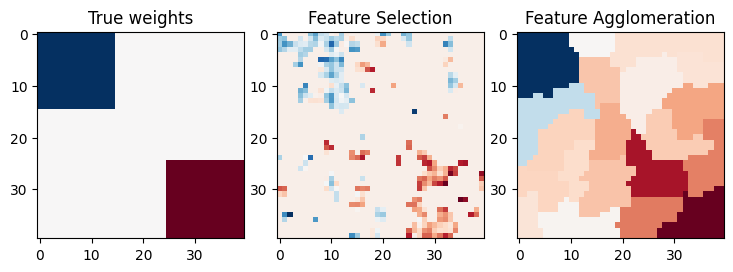

In [ ]:
plt.close("all")
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1, 3, 1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1, 3, 2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()

In [ ]:
shutil.rmtree(cachedir, ignore_errors=True)

# **Agglomerative Clustering with and without Structure**

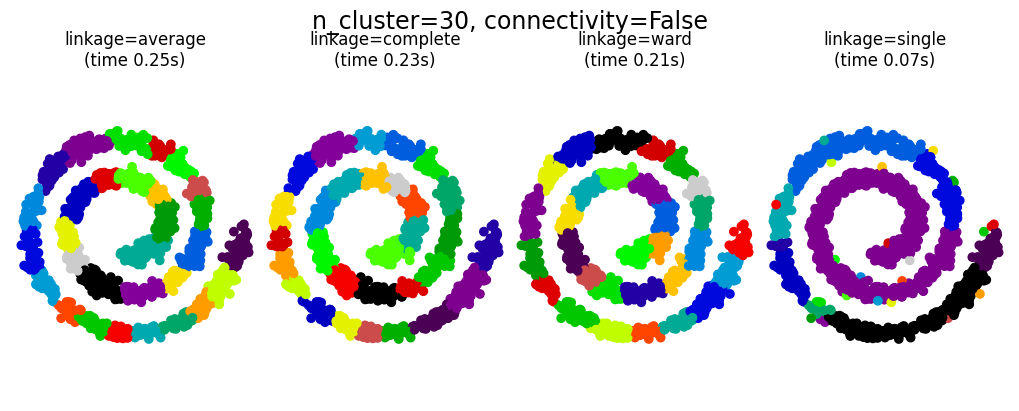

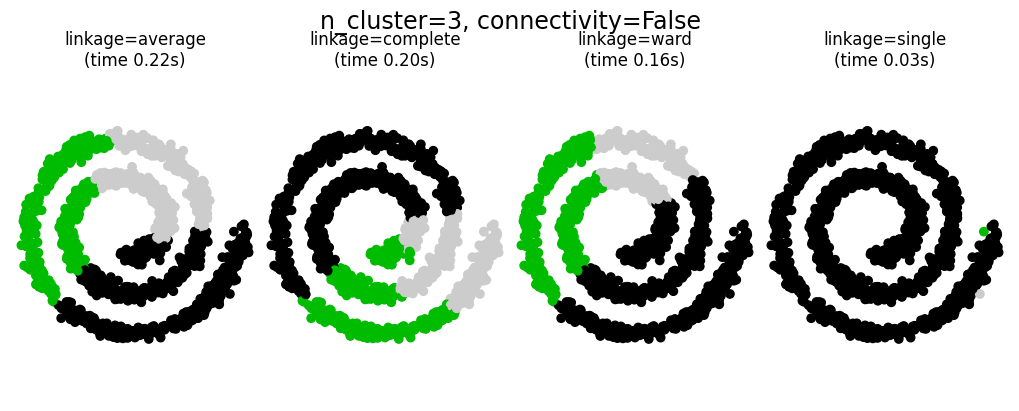

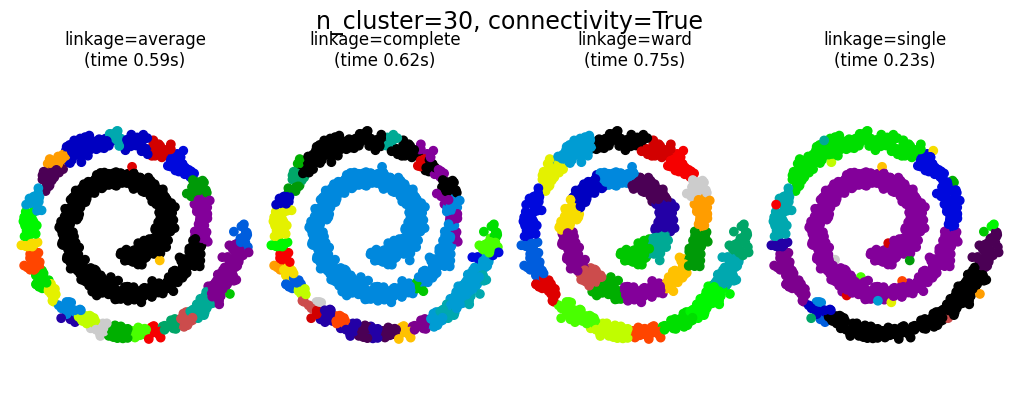

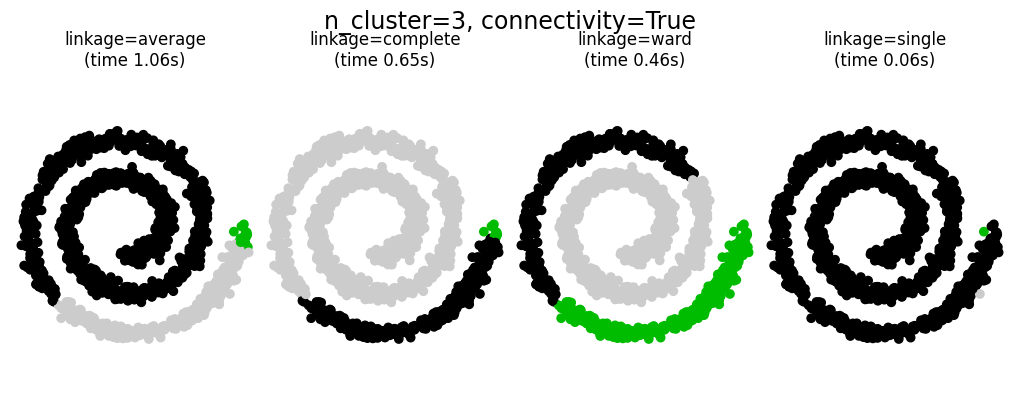

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += 0.7 * np.random.randn(2, n_samples)
X = X.T

knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(("average", "complete", "ward", "single")):
            plt.subplot(1, 4, index + 1)
            model = AgglomerativeClustering(
                linkage=linkage, connectivity=connectivity, n_clusters=n_clusters
            )
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)
            plt.title(
                "linkage=%s\n(time %.2fs)" % (linkage, elapsed_time),
                fontdict=dict(verticalalignment="top"),
            )
            plt.axis("equal")
            plt.axis("off")

            plt.subplots_adjust(bottom=0, top=0.83, wspace=0, left=0, right=1)
            plt.suptitle(
                "n_cluster=%i, connectivity=%r"
                % (n_clusters, connectivity is not None),
                size=17,
            )


plt.show()

# **Agglomerative Clustering with Different Metrics**

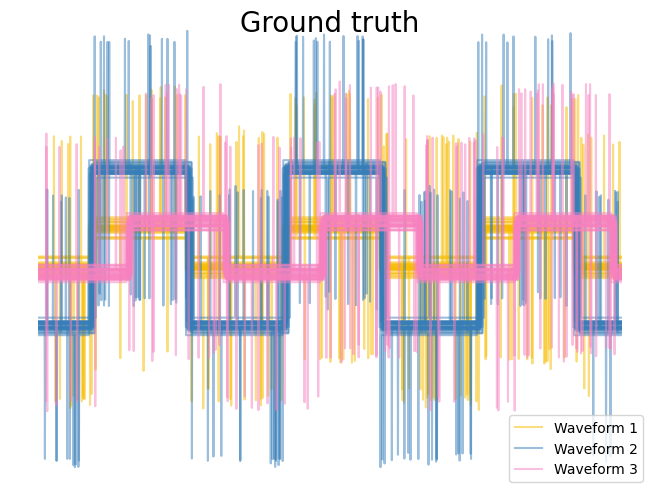

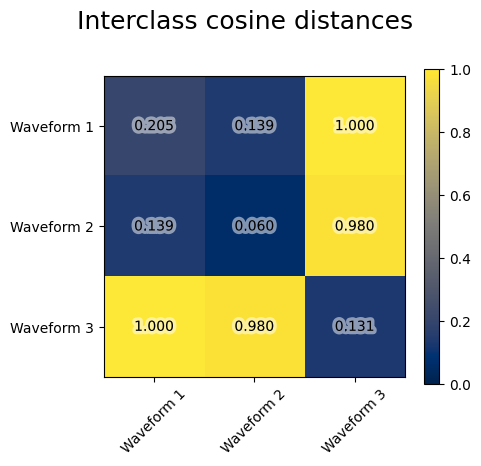

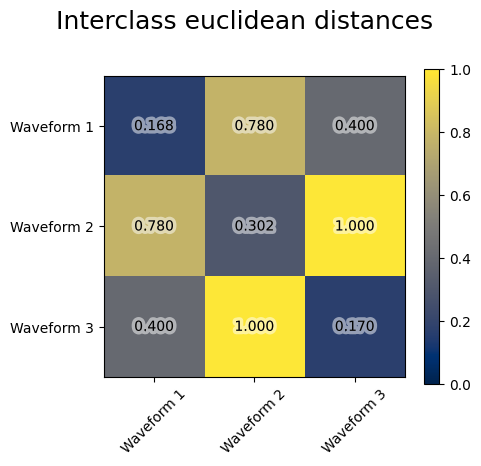

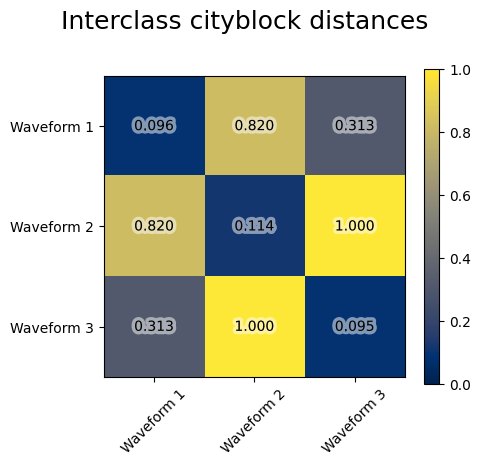

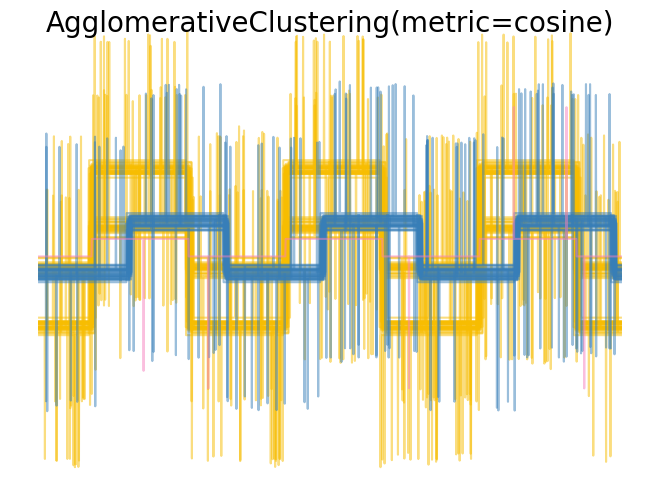

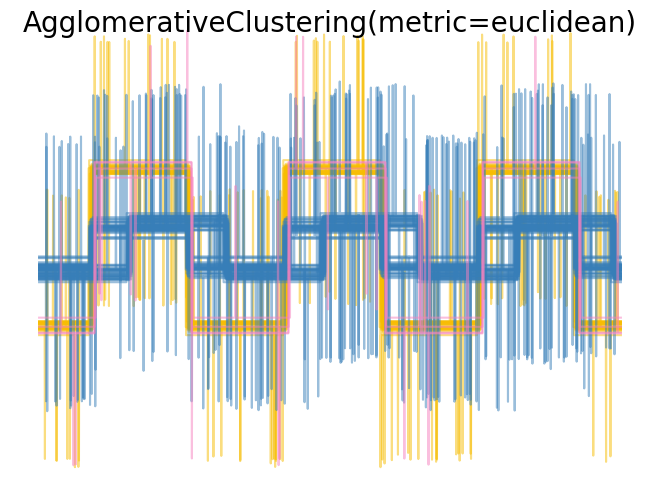

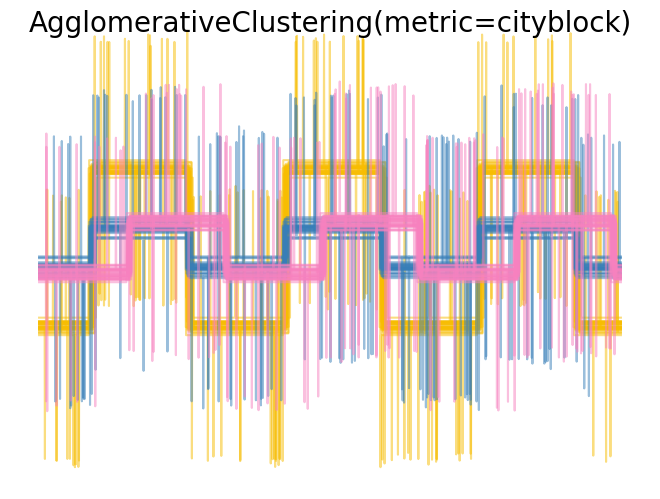

In [1]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

np.random.seed(0)

n_features = 2000
t = np.pi * np.linspace(0, 1, n_features)


def sqr(x):
    return np.sign(np.cos(x))


X = list()
y = list()
for i, (phi, a) in enumerate([(0.5, 0.15), (0.5, 0.6), (0.3, 0.2)]):
    for _ in range(30):
        phase_noise = 0.01 * np.random.normal()
        amplitude_noise = 0.04 * np.random.normal()
        additional_noise = 1 - 2 * np.random.rand(n_features)

        additional_noise[np.abs(additional_noise) < 0.997] = 0

        X.append(
            12
            * (
                (a + amplitude_noise) * (sqr(6 * (t + phi + phase_noise)))
                + additional_noise
            )
        )
        y.append(i)

X = np.array(X)
y = np.array(y)

n_clusters = 3

labels = ("Waveform 1", "Waveform 2", "Waveform 3")

colors = ["#f7bd01", "#377eb8", "#f781bf"]

plt.figure()
plt.axes([0, 0, 1, 1])
for l, color, n in zip(range(n_clusters), colors, labels):
    lines = plt.plot(X[y == l].T, c=color, alpha=0.5)
    lines[0].set_label(n)

plt.legend(loc="best")

plt.axis("tight")
plt.axis("off")
plt.suptitle("Ground truth", size=20, y=1)


for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    avg_dist = np.zeros((n_clusters, n_clusters))
    plt.figure(figsize=(5, 4.5))
    for i in range(n_clusters):
        for j in range(n_clusters):
            avg_dist[i, j] = pairwise_distances(
                X[y == i], X[y == j], metric=metric
            ).mean()
    avg_dist /= avg_dist.max()
    for i in range(n_clusters):
        for j in range(n_clusters):
            t = plt.text(
                i,
                j,
                "%5.3f" % avg_dist[i, j],
                verticalalignment="center",
                horizontalalignment="center",
            )
            t.set_path_effects(
                [PathEffects.withStroke(linewidth=5, foreground="w", alpha=0.5)]
            )

    plt.imshow(avg_dist, interpolation="nearest", cmap="cividis", vmin=0)
    plt.xticks(range(n_clusters), labels, rotation=45)
    plt.yticks(range(n_clusters), labels)
    plt.colorbar()
    plt.suptitle("Interclass %s distances" % metric, size=18, y=1)
    plt.tight_layout()


for index, metric in enumerate(["cosine", "euclidean", "cityblock"]):
    model = AgglomerativeClustering(
        n_clusters=n_clusters, linkage="average", metric=metric
    )
    model.fit(X)
    plt.figure()
    plt.axes([0, 0, 1, 1])
    for l, color in zip(np.arange(model.n_clusters), colors):
        plt.plot(X[model.labels_ == l].T, c=color, alpha=0.5)
    plt.axis("tight")
    plt.axis("off")
    plt.suptitle("AgglomerativeClustering(metric=%s)" % metric, size=20, y=1)


plt.show()